# Quotations Behind Brexit

Brexit (a portmanteau of "British exit") was the withdrawal of the United Kingdom (UK) from the European Union (EU) at 23:00 GMT on 31 January 2020 (00:00 CET). The UK is the first and so far the only member state to have left the EU, after 47 years of having been a part of the union — the EU and its predecessor the European Communities (EC), which included the European Economic Community — since 1 January 1973.
Actually, the United Kindom was considering about exiting the EU ever since 2016. After several referendums and negotiations between UK-EU, they finally exit the EU in early January, 2020. And the withdrawl aggrement finally came into force on 31 January 2020.
In our project, we would like to dive into quotations talking about the Brexit and analyze information behind these quotations to learn about people's attitude through the whole event.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

import os
import re
from os import path
import numpy as np
from PIL import Image
from functools import reduce
from string import punctuation
from itertools import chain
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim import models
from gensim import corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import plotly
import plotly_express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas(desc="progress-bar")

### Load the enriched dataset with additional information like gender, occupation and age.

In [7]:
df = pd.read_csv('./data/brexit_enriched_age.csv.bz2', compression='bz2', sep=',',index_col=0)
brexit_enriched = pd.read_json('./data/brexit_enriched_age.json.bz2', compression='bz2')
df.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0


In [8]:
# derive the speakers with the maximum probability
speaker_max_prob = df['probas'].apply(lambda x: x[1:-1].split(',')[0])

# get rid of redundant symbols in strings
speaker_max_prob = speaker_max_prob.apply(lambda x: x.strip('[').replace('\'',''))

# filter out the rows where the speaker assigned is diiferent from the speaker with the maximum probability
df = df[df['speaker'] == speaker_max_prob]

# filter out the rows where the probability of the asignned speaker is lower than 0.5
prob = df['probas'].apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[1].strip(']').replace('\'',''))
df = df[prob.astype(float) > 0.5]

df.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0


### Speakers Talking about the Brexit Most Frequently
We will have a look at who are the speakers talking about the Brexit most frequently.

In [9]:
df_speaker = df.groupby(['speaker_qid']).agg({'speaker_qid': ['count']}).sort_values(by=('speaker_qid', 'count'), ascending=False)
df_speaker = df_speaker[:20].reset_index()
df_speaker.head()

speaker_qid      
              count
0     Q264766  3285
1     Q180589  2795
2     Q318471  1820
3     Q291169  1528
4     Q467112  1379

In [10]:
df_speaker['Speaker']=['Theresa May','Boris Johnson','Nigel Farage','Jeremy Corbyn','Nicola Sturgeon',
                       'Donald Tusk','Leo Varadkar','Vince Cable','Simon Coveney','Michel Barnier',
                       'Jeremy Hunt','Tony Blair','Mark Carney','Jacob Rees-Mogg','Keir Starmer',
                       'Philip Hammond','Jo Swinson','David Davis','Ian Blackford','Tim Farron']

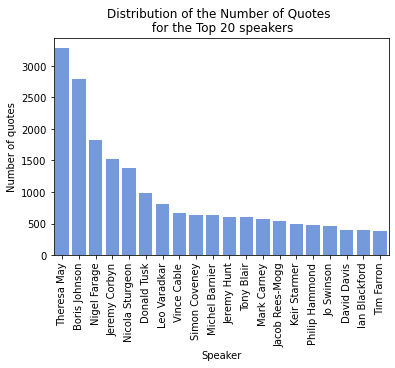

In [11]:
ax = sns.barplot(data = df_speaker, x = 'Speaker', y=('speaker_qid', 'count'),  color='cornflowerblue',alpha=1)
ax.set_xticklabels(df_speaker['Speaker'], rotation=90)
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 speakers')
plt.ylabel('Number of quotes')
plt.show()

### Where these Quotations come from ?
Let's first have a look at where these quotations come from by analyzing the nationalities of different speakers on the Brexit.

In [12]:
Nations = brexit_enriched['nationality'].explode().value_counts()
Top20_Nations = Nations[:20]
Top20_Nations.head()

United Kingdom              53891
United States of America    11653
Ireland                      6898
Australia                    2648
Canada                       2342
Name: nationality, dtype: int64

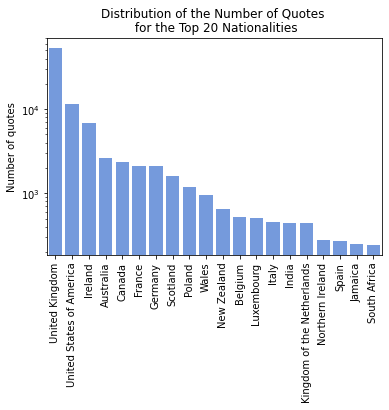

In [13]:
ax = sns.barplot(Top20_Nations.index, Top20_Nations.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Top20_Nations.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 Nationalities')
plt.ylabel('Number of quotes')
plt.show()

After visualizing the top 20 nations talking about the Brexit, it's obvious that most of speakers talking about the Brexit came from dominant countries in the world, for example, the United Kindom, the United States of America, Australia and so on. As this event, Brexit, was mostly about the European situation, we can observe that most countries in the top 20 nations talking about the Brexit were from the Europe, which shows that people care about the Brexit are mostly from the Europe.

### Gender of Speakers about the Brexit
We also investigate the gender distribution of speakers

In [14]:
Gender = brexit_enriched['gender'].explode().value_counts()
Gender.head()

male                75881
female              19200
eunuch                 31
cisgender female       26
non-binary             14
Name: gender, dtype: int64

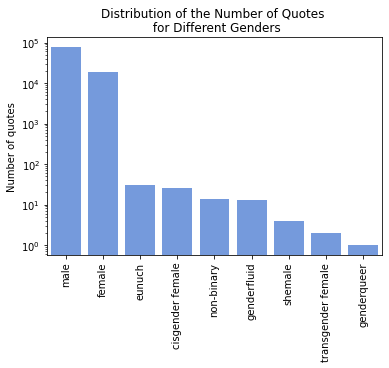

In [15]:
ax = sns.barplot(Gender.index, Gender.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Gender.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for Different Genders')
plt.ylabel('Number of quotes')
plt.show()

### Speakers' Occupation behind Brexit-related Quotations
Their occupation distribution is showm below.

In [16]:
Occupations = brexit_enriched['occupation'].explode().value_counts()
Top20_Occupations = Occupations[:20]
Top20_Occupations.head()

politician    54383
journalist     9374
writer         8021
lawyer         6583
economist      4894
Name: occupation, dtype: int64

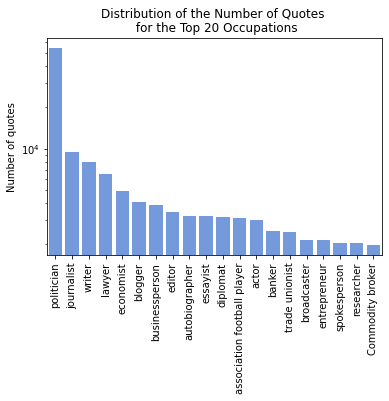

In [17]:
ax = sns.barplot(Top20_Occupations.index, Top20_Occupations.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Top20_Occupations.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 Occupations')
plt.ylabel('Number of quotes')
plt.show()

### Quotations numbers change from 2016 to 2020
We want to see how the number of quotations change from 2016 to 2020. In this way, we can obtain the popularity change of Brexit in this period.

In [18]:
df["year"] = df["date"].apply(lambda x :x.split("-")[0])
df["month"] = df["date"].apply(lambda x :x.split("-")[1])
change_by_year = df.groupby(["year","month"])["date"].count().reset_index()
change_by_year.rename(columns={"date": "count"},inplace = True)
change_by_year["year_month"] = change_by_year.year + "-" + change_by_year.month
change_by_year.head()

,year,month,count,year_month
0,2016,01,1,2016-01
1,2016,02,154,2016-02
2,2016,03,2,2016-03
3,2016,04,166,2016-04
4,2016,05,498,2016-05


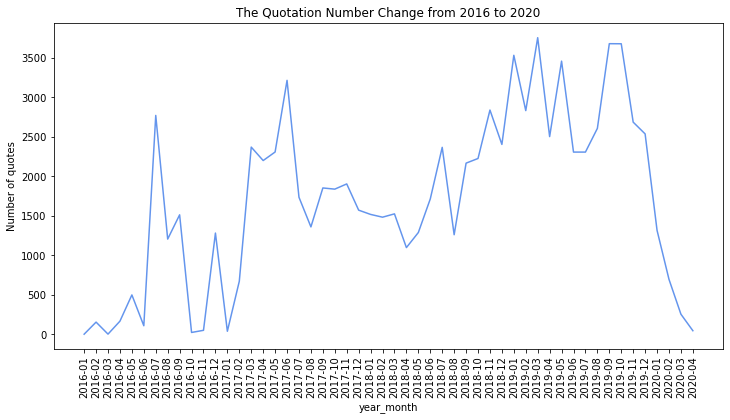

In [19]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data = change_by_year, x = 'year_month', y= 'count',  color='cornflowerblue',alpha=1)
ax.set_xticklabels(change_by_year['year_month'], rotation=90)
ax.set_title('The Quotation Number Change from 2016 to 2020')
plt.ylabel('Number of quotes')
plt.show()

### Topic Detection
We are curious about the content of quotations so that we can gain more insight of how the British people think about Brexit. Here we apply topic detection techniques to get the topic of these quotations. 

In [20]:
# get the quotation dataframe
qutation_data = df[["date","quotation"]]
qutation_data.head()

,date,quotation
0,2016-09-07,Corbyn shows his true colours. Rather than att...
1,2016-08-11,People are nervous and universities are being ...
2,2016-07-05,best placed to help forge a great post Brexit ...
3,2016-12-14,In the run-up to the Brexit vote earlier this ...
4,2016-07-25,"On the issue of Brexit, I speak for the people..."


#### Build Tokenizer
Here we build a tokenizer. This will, for every quotation:
1. lowercase the text and clean it (separate function)
2. break the descriptions into sentences and then break the sentences into tokens
3. remove punctuation, stop words
The first step is done by the clean_text function defined below.

Tokenization is a process to seprate the sentences into single words and punctuations.The second step is done by sent_tokenize from nltk.tokenize and word_tokenize from nltk.tokenize.

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. We have adopted stopwords file from https://github.com/ahmedbesbes/How-to-mine-newsfeed-data-and-extract-interactive-insights-in-Python/blob/master/data/stopwords.txt. We also add the stopword from nltk.corpus. Here you can also add your stopword into the additional_stop_words list.

In [21]:
# They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [22]:
# define a set of meaningless words. Most of them are not related to attitude. 
useless_words = ['one'  , 'could'  , 'many'  , 'also'  , 'years'  , 'well'  , 'would'  , 'us'   , 'time'   , 'two', 
                 'back' , 'today'  , 'even'  , 'said'  , 'last'   , 'see'   , 'since'  , 'like' , 'another', 'long',
                 'first', 'may'    , 'com'   , 'men'   , 'use'    , 'late'  , 'ever'   , 'home' , 'able'   , 'day',
                 'end'  , 'comm'   , 'mtg'   , 'making', 'think'  , 'mentioned', 'thinking'     , 'plane',
                 'sure' , 'docx'   , 'turned', 'call'  , 'coming' , 'toward' , 'million', 'man'  , 'possible',
                 'asked', 'send'   , 'got'   ,'percent', 'led'    , 'big'   , 'mills', 'dtype'  ,  'week', 'month', 'thing',
                 'feel' , 'lot'    , 'deal'  , 'people', 'good'   , 'issue' , 'country', 'thing', 'go'  , 'happen', 'kind' ,
                 'talk' , 'great'  , 'moment', 'year'  , 'term'   , 'month' , 'three']

# load the stopwords file 
stop_words = []
f = open('stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))

stop_words.extend(useless_words)

# interface for adding words to the stop_words list
additional_stop_words = ['t', 'will']
stop_words =  stop_words + additional_stop_words + stopwords.words('english')
print("The total stopword is {}".format(len(stop_words)))

The total stopword is 923


In [23]:
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [24]:
qutation_data['tokens'] = qutation_data['quotation'].progress_map(lambda d: tokenizer(d))

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

In [25]:
qutation_data.head()

,date,quotation,tokens
0,2016-09-07,Corbyn shows his true colours. Rather than att...,"[corbyn, true, colours, attacking, divided, br..."
1,2016-08-11,People are nervous and universities are being ...,"[nervous, universities, defensive, eu, student..."
2,2016-07-05,best placed to help forge a great post Brexit ...,"[best, help, forge, post, brexit, future, brit..."
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,"[brexit, vote, earlier, fed, policymakers, cit..."
4,2016-07-25,"On the issue of Brexit, I speak for the people...","[brexit, speak, north, north, unionists, natio..."


#### Part of Speech Tagging and Lemmatization
Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.

Generally, lemmatization is followed by Part of Speech Tagging (POS-Tag), which is the labeling of the words in a text according to their word types (noun, adjective, adverb, verb, etc.) POS tagging is a supervised learning solution that uses features like the previous word, next word, is first letter capitalized etc. NLTK has a function to get pos tags and it works after tokenization process. Detailed tags can be found here(https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

NLTK provides WordNetLemmatizer class which is a thin wrapper around the wordnet corpus.

In [26]:
qutation_data['POS_tokens'] = qutation_data['tokens'].progress_map(lambda tokens: pos_tag(tokens))

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

In [27]:
qutation_data.head()

,date,quotation,tokens,POS_tokens
0,2016-09-07,Corbyn shows his true colours. Rather than att...,"[corbyn, true, colours, attacking, divided, br...","[(corbyn, NN), (true, JJ), (colours, NNS), (at..."
1,2016-08-11,People are nervous and universities are being ...,"[nervous, universities, defensive, eu, student...","[(nervous, JJ), (universities, NNS), (defensiv..."
2,2016-07-05,best placed to help forge a great post Brexit ...,"[best, help, forge, post, brexit, future, brit...","[(best, JJS), (help, NN), (forge, VB), (post, ..."
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,"[brexit, vote, earlier, fed, policymakers, cit...","[(brexit, NN), (vote, NN), (earlier, RBR), (fe..."
4,2016-07-25,"On the issue of Brexit, I speak for the people...","[brexit, speak, north, north, unionists, natio...","[(brexit, NN), (speak, JJ), (north, JJ), (nort..."


In [28]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()
qutation_data['tokens_after_lemmatized'] = qutation_data['POS_tokens'].progress_map(
    lambda list_tokens_POS:
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in list_tokens_POS
        ] 
        
)

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

#### Phrase detection
We need to automatically detect common phrases like multi-word expressions, word n-gram collocations from a stream of tokens. Here we use bigram and trigram

In [29]:
tokens = qutation_data['tokens_after_lemmatized'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Create the dictionary
In Gensim, the dictionary object is used to create a bag of words (BoW) corpus which further used as the input to topic modelling and other models as well.

Corpus − It refers to a collection of documents as a bag of words (BoW).

Here we define three functions:
1. LDA_model, this function returns the LDA model
2. compute_coherence, this function is used to compute coherence score to evaluate the LDA model
3. display_topics, function to display topics and corresponding keywords:
3. explore model. this is a tuning function, used to explore different topics of LDA models.

In [30]:
dict_LDA = corpora.Dictionary(tokens)
dict_LDA.filter_extremes(no_below=1)
corpus = [dict_LDA.doc2bow(tok) for tok in tokens]

def LDA_model(num_topics,corpus, id2word, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )
def compute_coherence(model,tokens, id2word):
    coherence = CoherenceModel(model=model, 
                           texts=tokens,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=num_words)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, num_words+1)]
    return df

def explore_models(corpus, id2word, tokens, rg=range(5, 25)):
    models = []
    coherences = []
    
    for num_topics in rg:
        lda_model = LDA_model(num_topics,corpus, id2word, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model, tokens, id2word)
        coherences.append(coherence)
      
    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models


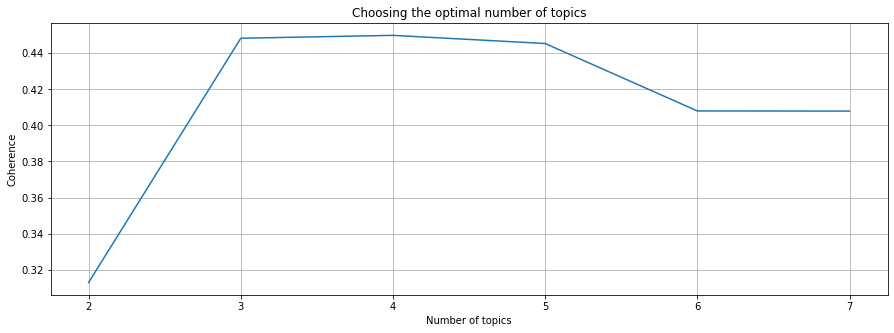

In [31]:
coherences, models = explore_models(corpus, dict_LDA, tokens, rg=range(2, 8))

In [32]:
best_model = LDA_model(num_topics=4, corpus=corpus, id2word=dict_LDA, passes=5)

display_topics(model=best_model, num_words=5)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
topic_0,uk,eu,government,hard,work
topic_1,vote,party,deliver,go,election
topic_2,uncertainty,risk,economy,impact,uk
topic_3,business,uk,continue,post,market


#### Visualization of LDA model

In [33]:
vis = pyLDAvis.gensim_models.prepare(topic_model=best_model, corpus=corpus, dictionary=dict_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [34]:
# save as html file
pyLDAvis.save_html(vis, 'lda.html')

### WordCloud to visialise words
We can use wordcloud to display important word and unimportant world.

In [35]:
# vectorize the bag of words
vectorizer = TfidfVectorizer(min_df=2, analyzer='word', ngram_range=(1, 3), stop_words='english')
vz = vectorizer.fit_transform(list(qutation_data['tokens_after_lemmatized'].map(lambda tokens: ' '.join(tokens))))
print(vz.shape)

(88881, 238332)


<AxesSubplot:>

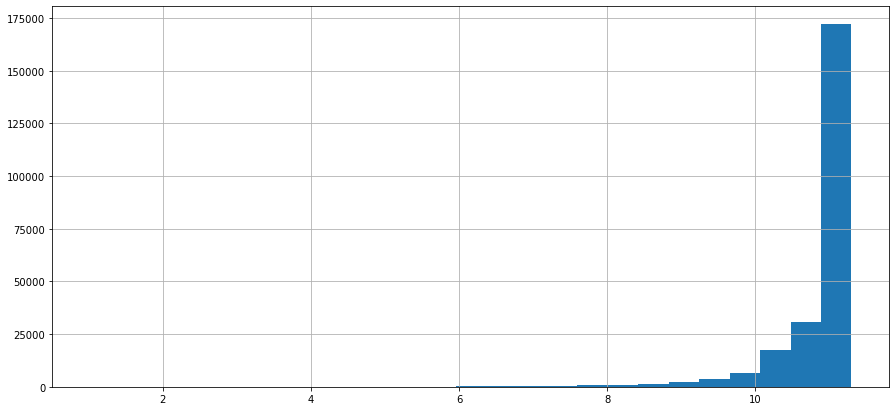

In [36]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# plot the distribution of the values of tf-idf matrix
tfidf.tfidf.hist(bins=25, figsize=(15,7))

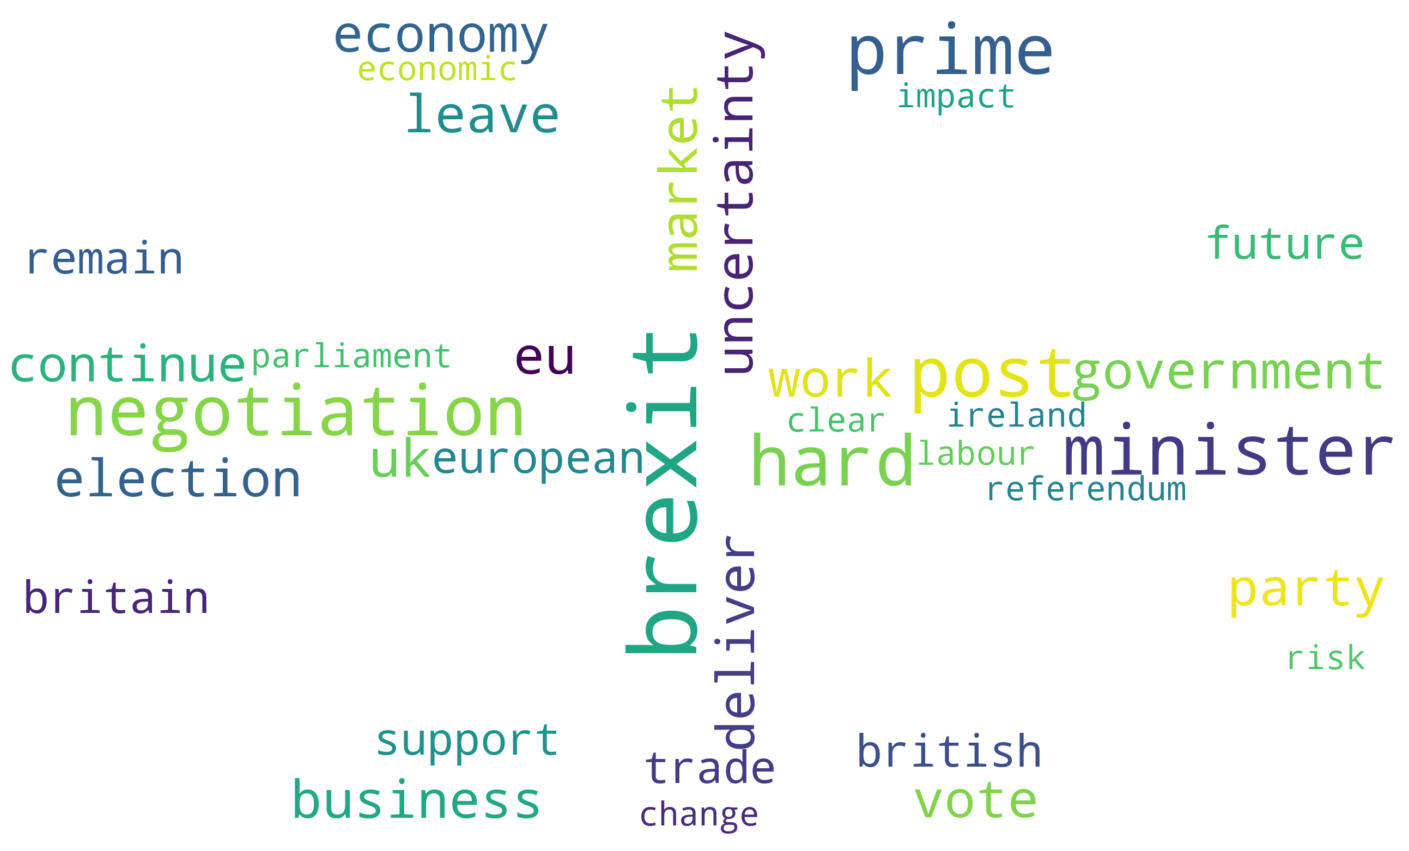

In [38]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))

    # lower max_font_size
    mask = np.array(Image.open('Flag_Britain.png'))
    wordcloud = WordCloud(background_color='white', mask=mask).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("WordClouds_of_Topics.png")

# plot the words= cloud
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))


### Sentiment Analysis


Transformers provides thousands of pretrained models to perform tasks on different modalities such as text, vision, and audio.  Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets. To immediately use a model on a given input (text, image, audio, ...), Transformers provides the pipeline API. Pipelines group together a pretrained model with the preprocessing that was used during that model's training. The default model (distilbert-base-uncased-finetuned-sst-2-english) can only handle the sentence length less than 512. So we filter out the quotation length larger than 512.

Since sentiment analysis takes a lot of time, we save the output to csv.bz.

In [50]:
# from transformers import pipeline
# classifier = pipeline('sentiment-analysis')

# uk_sentiment = df.loc[df.nationality.str.contains('United Kingdom') == True]
# uk_sentiment["quotation_length"] = uk_sentiment["quotation"].apply(lambda x: len(x))
# uk_sentiment = uk_sentiment[uk_sentiment["quotation_length"]< 512]
# uk_sentiment.drop("quotation_length", axis = 1,inplace = True)

# uk_sentiment['sentiment_label'] = uk_sentiment["quotation"].apply(lambda x: classifier(x)[0]["label"] )
# uk_sentiment.to_csv("./data/uk_people_sentiment_len_lt_512.csv.bz2", compression = "bz2")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [53]:
uk_sentiment = pd.read_csv('./data/uk_people_sentiment_len_lt_512.csv.bz2', compression='bz2', sep=',',index_col=0)
uk_sentiment.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age,sentiment_label
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0,NEGATIVE
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0,POSITIVE
5,2016-04-29,The unknowns of Brexit are unwelcome at a time...,Andrew Mackenzie,"['Q15042554', 'Q21456523', 'Q4275769', 'Q43914...","[['Andrew Mackenzie', '0.7529'], ['None', '0.1...",Q15042554,+1956-12-20T00:00:00Z,['United Kingdom'],['male'],"['entrepreneur', 'chief executive officer', 'g...",Andrew Mackenzie,65.0,NEGATIVE
7,2016-07-23,"Brexit means us being more outward-looking, mo...",Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7609'], ['None', '0.2331...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0,POSITIVE
11,2016-09-11,"In terms of support for independence, most pol...",Ruth Davidson,['Q2177593'],"[['Ruth Davidson', '0.549'], ['None', '0.451']]",Q2177593,+1978-11-10T00:00:00Z,['United Kingdom'],['female'],"['politician', 'journalist']",Ruth Davidson,43.0,POSITIVE


This function can get the dataframe to plot the graph. The graph can show the quotation number and proportion change by month. 

In [116]:
def change_by_month(df, name):
    # if the name is not none, it will output quotation of the specific people.
    if name == None:
        name_selection = df   
    else:
        name_selection = df[df["speaker"] == name]
    name_selection["year"] = name_selection["date"].apply(lambda x :x.split("-")[0])
    name_selection["month"] = name_selection["date"].apply(lambda x :x.split("-")[1])
    month_change = name_selection.groupby(["year","month","sentiment_label"])["quotation"].count().reset_index()
    month_change["year_month"] = month_change.year + "-" +month_change.month
    month_change.rename(columns={"quotation": "count"},inplace = True)
    
    #Here we calculate the percentage of positive or negative quotation in each month.
    sum_by_month = month_change.groupby(["year","month"])["count"].sum().reset_index()
    sum_by_month.rename(columns={"count": "sum_by_month"},inplace = True)
    month_change = month_change.merge(sum_by_month, on = ["year","month"])
    month_change["percentage"] = month_change["count"]/month_change["sum_by_month"]
    return month_change
    

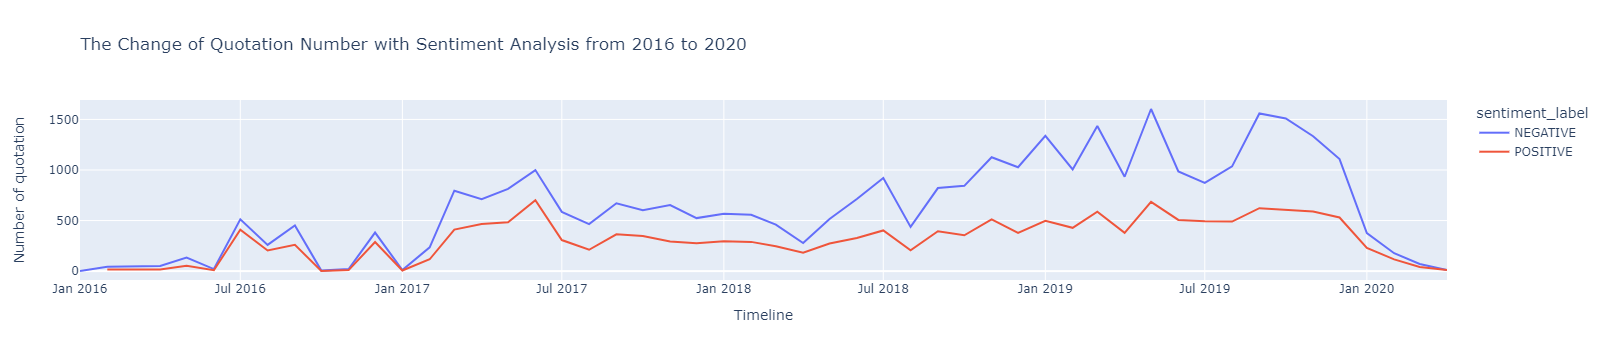

In [127]:
all_uk_people = change_by_month(uk_sentiment, None)
fig = px.line(all_uk_people, x="year_month", y="count", title='The Change of Quotation Number with Sentiment Analysis from 2016 to 2020',color='sentiment_label',
              labels={
                     "year_month": "Timeline",
                     "count": "Number of quotation",
                 })
fig.show()

In [128]:
import plotly
plotly.offline.plot(fig, filename='quotation_with_sentiment.html')

'quotation_with_sentiment.html'

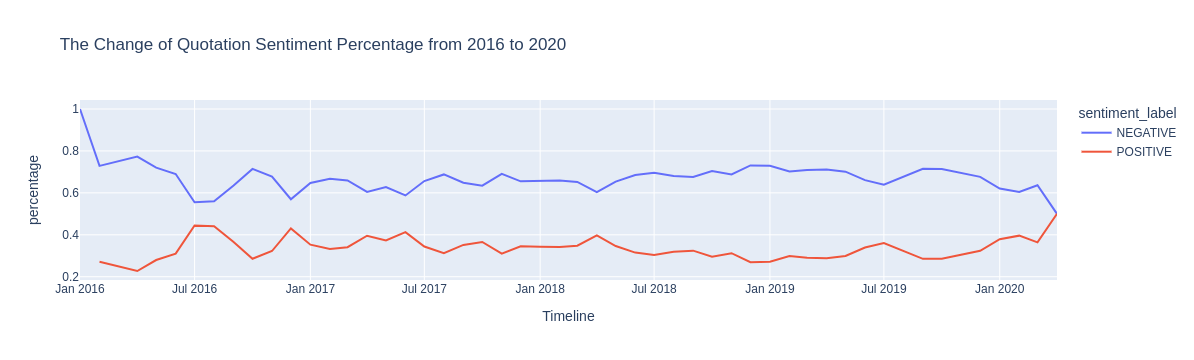

In [133]:
fig = px.line(all_uk_people, x="year_month", y="percentage", title='The Change of Quotation Sentiment Percentage from 2016 to 2020',color='sentiment_label',
          labels={
                 "year_month": "Timeline",
                 "count": "Percentage of quotation sentiment",
             })
fig.show()

In [134]:
import plotly
plotly.offline.plot(fig, filename='quotation_percentage.html')

'quotation_percentage.html'

We want see the quotation sentiment change on the basis of months from 2016 to 2020.

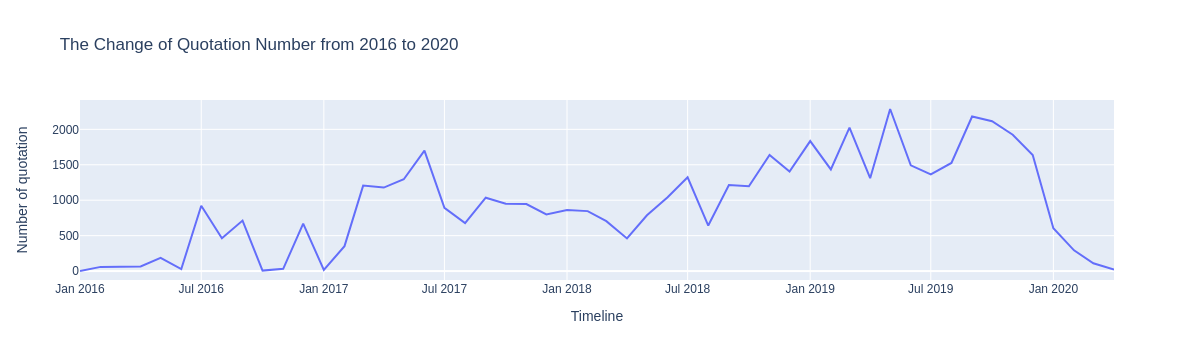

In [131]:
uk_quotation_month_change = uk_sentiment.groupby(["year","month"])["quotation"].count().reset_index()
uk_quotation_month_change["year_month"] = uk_quotation_month_change.year + "-" +uk_quotation_month_change.month
uk_quotation_month_change.rename(columns={"quotation": "count"},inplace = True)

fig = px.line(uk_quotation_month_change, x="year_month", y="count", title='The Change of Quotation Number from 2016 to 2020',
              labels={
                     "year_month": "Timeline",
                     "count": "Number of quotation",
                 })
fig.show()

In [132]:
import plotly
plotly.offline.plot(fig, filename='quotation_number.html')

'quotation_number.html'

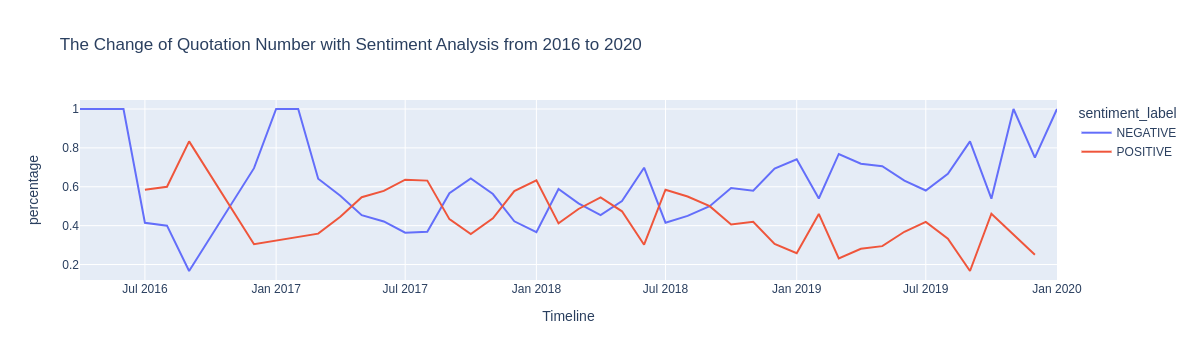

In [113]:
Theresa = change_by_month(uk_sentiment, "Theresa May")
fig = px.line(boris, x="year_month", y="percentage", title='The Change of Quotation Number with Sentiment Analysis from 2016 to 2020', color = "sentiment_label",
              labels={
                     "year_month": "Timeline",
                     "count": "Number of quotation",
                 })
fig.show()

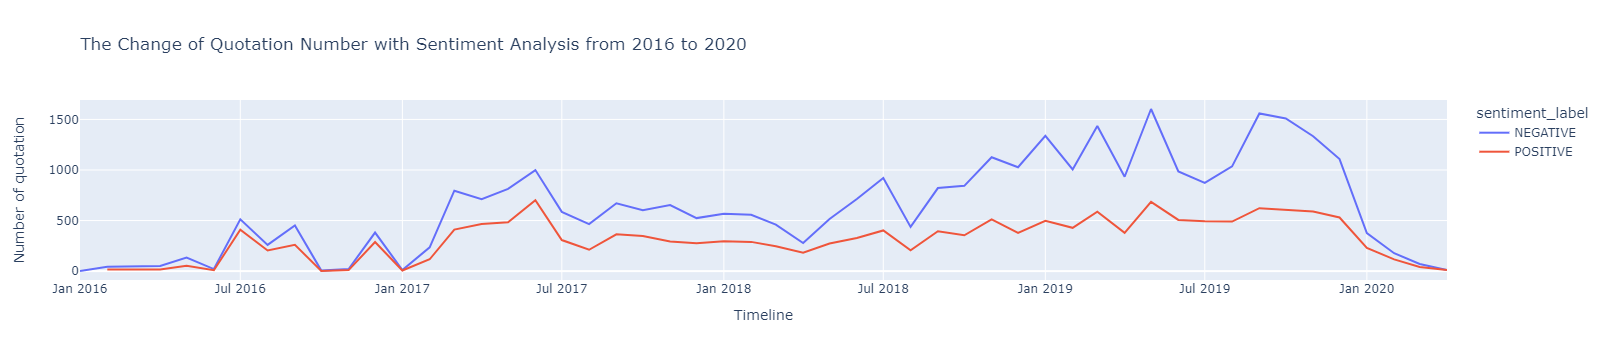

In [117]:
sentiment_month_change = change_by_month(uk_sentiment, None)
fig = px.line(sentiment_month_change, x="year_month", y="count", title='The Change of Quotation Number with Sentiment Analysis from 2016 to 2020',color='sentiment_label',
              labels={
                     "year_month": "Timeline",
                     "count": "Number of quotation",
                 })
fig.show()

In [33]:
import plotly
plotly.offline.plot(fig, filename='quotation_with_sentiment.html')

'quotation_with_sentiment.html'

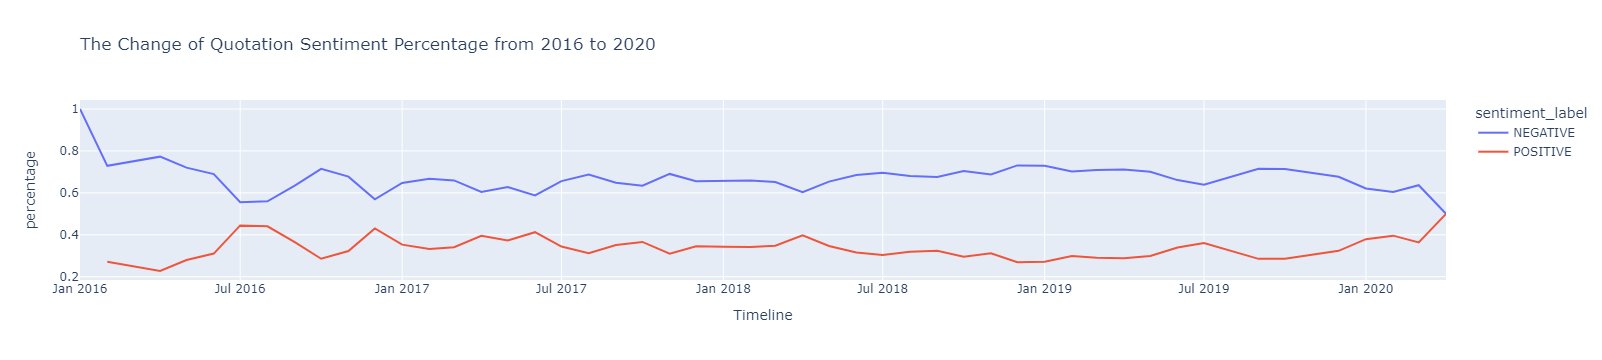

In [59]:
fig = px.line(sentiment_month_change, x="year_month", y="percentage", title='The Change of Quotation Sentiment Percentage from 2016 to 2020',color='sentiment_label',
              labels={
                     "year_month": "Timeline",
                     "count": "Percentage of quotation sentiment",
                 })
fig.show()

In [35]:
import plotly
plotly.offline.plot(fig, filename='quotation_percetage.html')

'quotation_percetage.html'

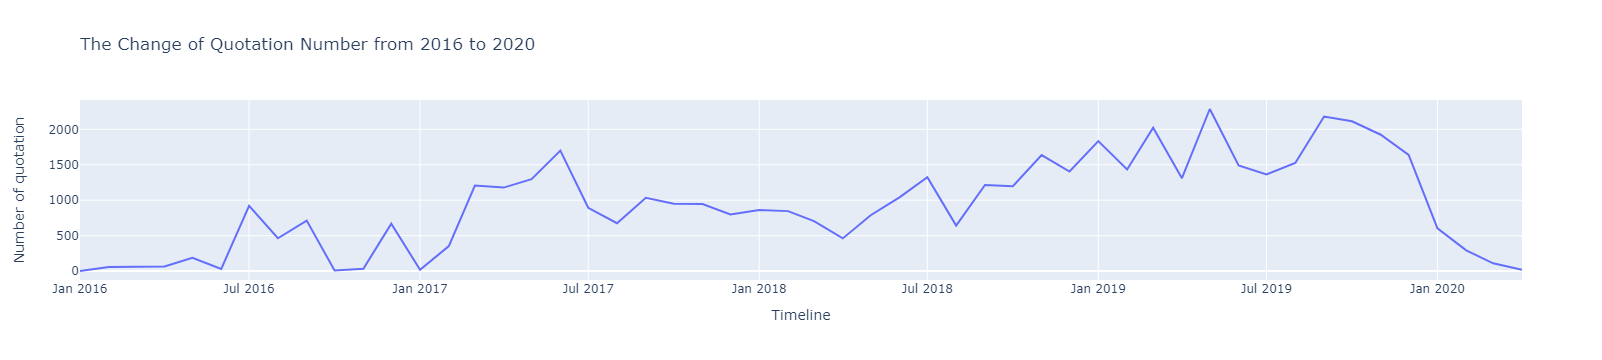

In [60]:
uk_quotation_month_change = uk_sentiment.groupby(["year","month"])["quotation"].count().reset_index()
uk_quotation_month_change["year_month"] = uk_quotation_month_change.year + "-" +uk_quotation_month_change.month
uk_quotation_month_change.rename(columns={"quotation": "count"},inplace = True)

fig = px.line(uk_quotation_month_change, x="year_month", y="count", title='The Change of Quotation Number from 2016 to 2020',
              labels={
                     "year_month": "Timeline",
                     "count": "Number of quotation",
                 })
fig.show()

In [38]:
import plotly
plotly.offline.plot(fig, filename='quotation_number.html')

'quotation_number.html'